### optimal freq range detection

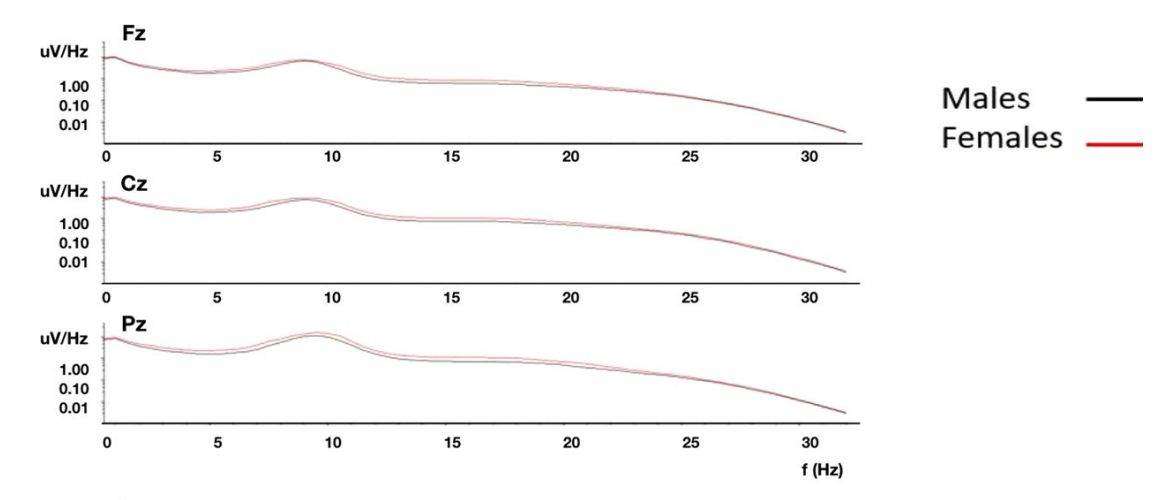

In [ ]:
!pwd

In [4]:
from data_loaders.dreem import DreemDataset
import numpy as np
import pandas as pd
import torch

In [5]:
d=DreemDataset("data/dreem/train/")

labels= pd.Series(d.labels.squeeze())
outliers=[14,721,439,943,934,622,149,460,556,220,219,603,519,788,799,191,402]
labels=labels.drop(outliers)
M_idx=labels[labels==0].index.values
F_idx=labels[labels==1].index.values

In [6]:
import h5py
d=h5py.File("./data/dreem/train/X_train_w0MYA72.h5",'r').get('features')

In [7]:
M=d[M_idx,:,:,:]
F=d[F_idx,:,:,:]

In [8]:
MM=np.concatenate(np.split(M,M.shape[0],axis=0),axis=1).squeeze()
FF=np.concatenate(np.split(F,F.shape[0],axis=0),axis=1).squeeze()

In [40]:
from torchaudio.transforms import Spectrogram

In [41]:
s=Spectrogram(n_fft=500,normalized=True,power=2)

In [42]:
M_spectr=[]
F_spectr=[]

In [43]:
for k in range(7):
    M_spectr.append(s(torch.tensor(MM[:,k,:])).log2()[:,:,1].mean(axis=0).numpy())
    F_spectr.append(s(torch.tensor(FF[:,k,:])).log2()[:,:,1].mean(axis=0).numpy())

In [ ]:
def get_freq_range(sampling_rate,window_size):
    return [sampling_rate/window_size *k for k in range(window_size//2+1)]

<IPython.core.display.Javascript object>


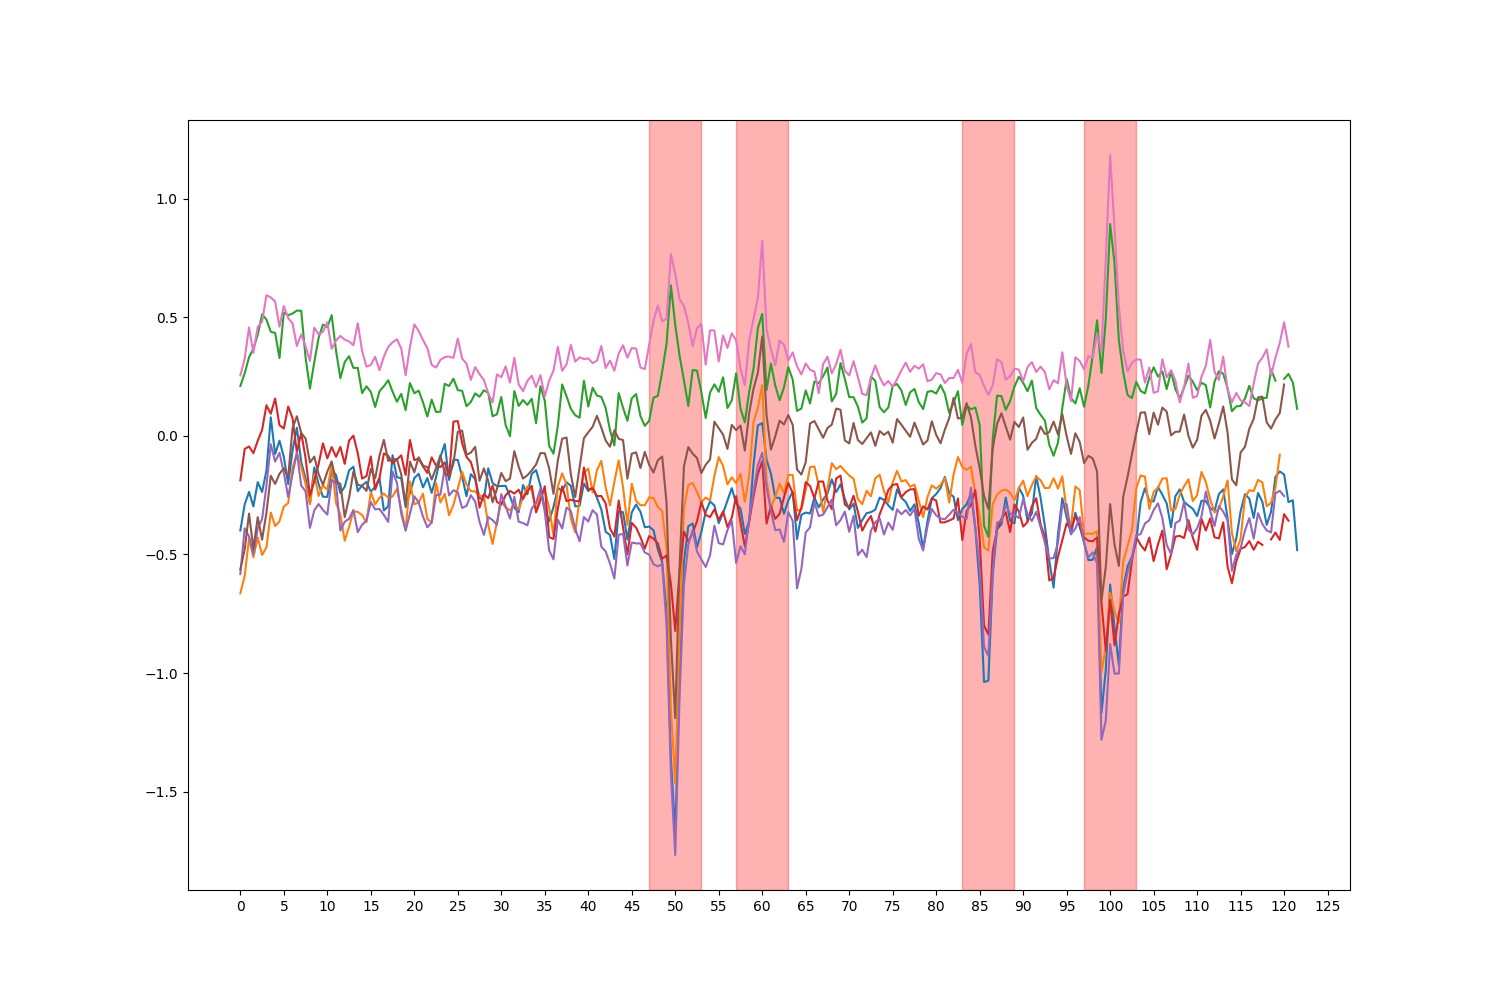

/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/home/rlmp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


In [90]:
#%matplotlib notebook
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))

freq = get_freq_range(250,500)
for k in range(7):
    plt.plot(freq,M_spectr[k]-F_spectr[k])

ax=plt.gca()
plt.xticks(np.arange(min(freq), max(freq)+1, 5.0))
good_bands=(50 , 60, 86,100 )
  
for k in good_bands:
    ax.axvspan(k-3, k+3, alpha=0.3, color='red')
    

In [9]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def gen_filter(x,low,high,fs=250,order=9):
    return abs(butter_bandpass_filter(x,low,high,fs,order))

In [216]:
from matplotlib import pyplot as plt
import tqdm
resH={}
for k in range(7):
    resH[k]=[]
    for H in tqdm.tqdm(M):
        for trial in range(40):
            X=H[trial,k,:]
            resH[k].append(gen_filter(X,96,104).sum())
                           


100%|██████████| 722/722 [00:12<00:00, 56.84it/s]


In [217]:
resF={}
for k in range(7):
    resF[k]=[]
    for FFF in tqdm.tqdm(F):
        for trial in range(40):
            X=FFF[trial,k,:]
            resF[k].append(gen_filter(X,96,104).sum())

100%|██████████| 207/207 [00:03<00:00, 55.88it/s]


In [218]:
import pandas as pd
import matplotlib.gridspec as gridspec
dH = pd.DataFrame(resH)
dF = pd.DataFrame(resF)


<IPython.core.display.Javascript object>


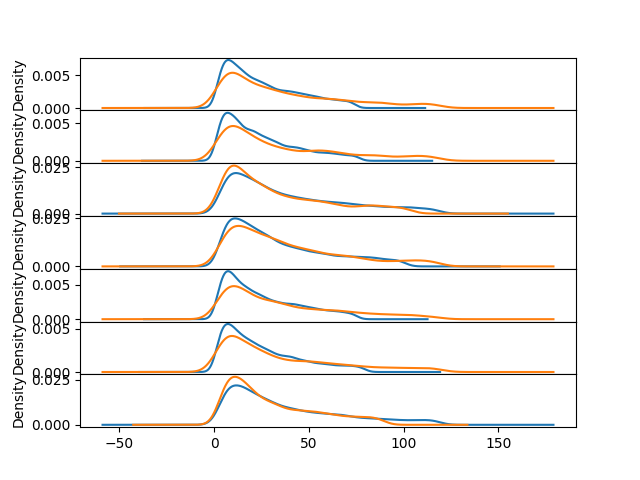

In [219]:
gs1 = gridspec.GridSpec(7, 1)
gs1.update(hspace=0.0) # set the spacing between axes. 
ax={}
Q=0.75
f.tight_layout()
for k in range(7):
    ax[k] = plt.subplot(gs1[k])
    qh=dH[k].quantile(Q)
    qf=dF[k].quantile(Q)
    dH[dH[k]<qh][k].plot(kind="kde",ax=ax[k])
    dF[dF[k]<qf][k].plot(kind="kde",ax=ax[k])
    